In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from zipfile import ZipFile

In [3]:
data_path = '/content/drive/MyDrive/Lung-Colon_CancerDataset/lung_colon_image_set.zip'

with ZipFile(data_path, 'r') as zip:
        zip.extractall()
        print('The dataset has been extracted.')

The dataset has been extracted.


In [4]:
path = '/content/lung_image_sets/'
classes = os.listdir(path)
print(classes)

['lung_scc', 'lung_n', 'lung_aca']


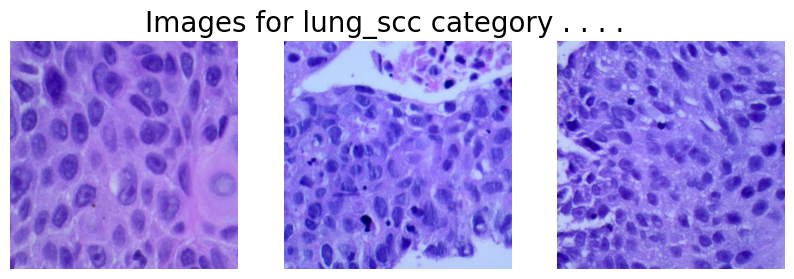

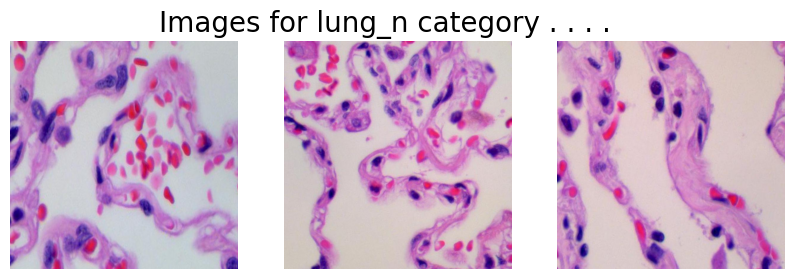

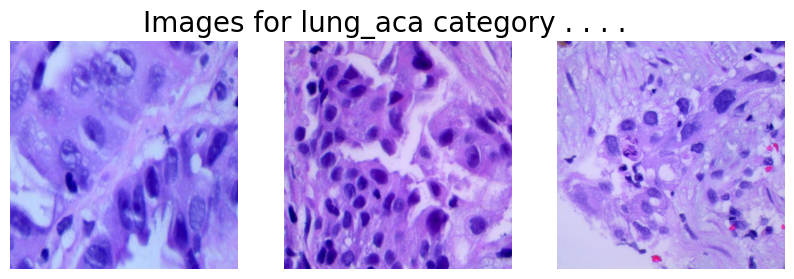

In [5]:
path = '/content/lung_image_sets'
for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(10, 3))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


#Histopathological Images

In [6]:
IMG_SIZE = 192
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 96


In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
      img = cv2.imread(image)

      X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
      Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 192, 192, 3) (3000, 192, 192, 3)


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freezing the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Increased dropout for better regularization
predictions = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
125/125 [==============================] - 185s 1s/step - loss: 2.0745 - accuracy: 0.8911 - val_loss: 0.1055 - val_accuracy: 0.9573
Epoch 2/10
125/125 [==============================] - 185s 1s/step - loss: 0.1290 - accuracy: 0.9495 - val_loss: 0.0798 - val_accuracy: 0.9683
Epoch 3/10
125/125 [==============================] - 188s 2s/step - loss: 0.1001 - accuracy: 0.9607 - val_loss: 0.0763 - val_accuracy: 0.9700
Epoch 4/10
125/125 [==============================] - 187s 1s/step - loss: 0.0817 - accuracy: 0.9688 - val_loss: 0.0636 - val_accuracy: 0.9760
Epoch 5/10
125/125 [==============================] - 186s 1s/step - loss: 0.0679 - accuracy: 0.9754 - val_loss: 0.0494 - val_accuracy: 0.9830
Epoch 6/10
125/125 [==============================] - 186s 1s/step - loss: 0.0618 - accuracy: 0.9770 - val_loss: 0.0498 - val_accuracy: 0.9830
Epoch 7/10
125/125 [==============================] - 185s 1s/step - loss: 0.

In [27]:
Y_pred = model.predict(X_val)

94/94 [==============================] - 42s 443ms/step


In [34]:
Y_val_new = np.argmax(Y_val, axis=1)
Y_pred_new = np.argmax(Y_pred, axis=1)

In [35]:
accuracy = metrics.accuracy_score(Y_val_new, Y_pred_new)
print("Accuracy:", accuracy)

Accuracy: 0.9856666666666667


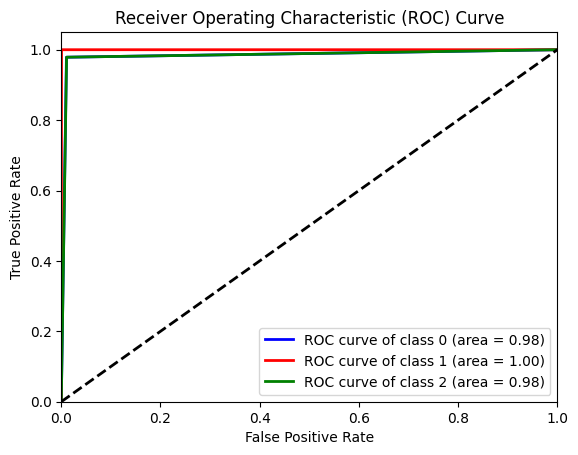

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multiclass ROC curve
Y_val_bin = label_binarize(Y_val_new, classes=[0, 1, 2])
Y_pred_bin = label_binarize(Y_pred_new, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class with different colors
plt.figure()
colors = ['blue', 'red', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 966,    0,   21],
       [   0,  977,    0],
       [  21,    1, 1014]])

In [16]:
model.save('/content/drive/MyDrive/model_new.h5')


In [17]:
from tensorflow import keras

# Replace 'path/to/your/model.h5' with the actual path to your model file in Google Drive.
model_path = "/content/drive/MyDrive/Lung-Colon_Cancer_model/model_new.h5"

# Load the model
loaded_model = keras.models.load_model(model_path)

# Now you can use loaded_model for prediction or further training

In [37]:
Y_pred_for_model = loaded_model.predict(X_val)

94/94 [==============================] - 42s 442ms/step


In [38]:
Y_val_new = np.argmax(Y_val, axis=1)
Y_pred_new = np.argmax(Y_pred_for_model, axis=1)

In [40]:
accuracy = metrics.accuracy_score(Y_val_new, Y_pred_new)
print("Accuracy:", accuracy)

Accuracy: 0.9856666666666667
